# The Jet Collection

The Jet collections is one of the more sophisticated collections in ATLAS. Below we'll look at:

* Getting jet attributes like $p_T$ and $\eta$
* Getting the constituents that went into building the jet
* How calibrations are applied, and how one can get at the systematic variations

In [1]:
from config import ds_zee as ds
from config import ds_jz3_exot15
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np
from func_adl_servicex_xaodr21 import cpp_float, cpp_vfloat

Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.


In [2]:
jets = (ds
        .SelectMany(lambda e: e.Jets("AntiKt4EMPFlowJets"))
        .Where(lambda j: (j.pt() / 1000) > 30)
        .Select(lambda j: j.pt() / 1000.0)
        .AsAwkwardArray('JetPt')
        .value())

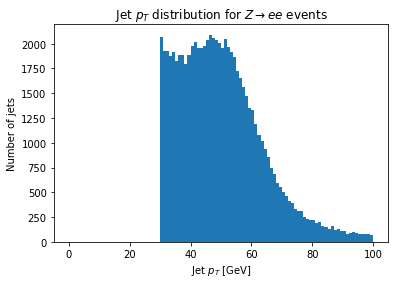

In [3]:
plt.hist(jets.JetPt, bins=100, range=(0, 100))
plt.xlabel('Jet $p_T$ [GeV]')
plt.ylabel('Number of jets')
_ = plt.title('Jet $p_T$ distribution for $Z\\rightarrow ee$ events')

## Jet Constituents

Jets are composed of `TopoClusters` in ATLAS, unfortunately, they are often skimmed away. They are not present, for example, in `DAOD_PHYS`, which is the skim being used here. We'll have to pull from a different file instead.

In [4]:
topo_clusters = (ds_jz3_exot15
                    .SelectMany(lambda e: e.Jets("AntiKt4EMTopoJets", truth_jets="AntiKt4TruthJets"))
                    .SelectMany(lambda j: j.getConstituents())
                    .Select(lambda tc: tc.pt())
                    .AsAwkwardArray('JetClusterPt')
                    .value()
                )

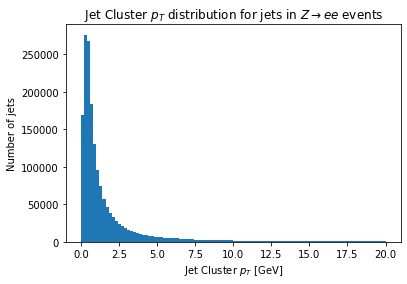

In [5]:
plt.hist(topo_clusters.JetClusterPt/1000.0, bins=100, range=(0, 20))
plt.xlabel('Jet Cluster $p_T$ [GeV]')
plt.ylabel('Number of jets')
_ = plt.title('Jet Cluster $p_T$ distribution for jets in $Z\\rightarrow ee$ events')

## Jet Attributes

Attributes are called _moments_ by the ATLAS Jet/ETMiss group. They are extra information that has been added into the jet object. The [Run 2 Moments Page](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/Run2JetMoments) lists all the moments. To access them you'll need to know the return type explicitly, and parameterize your call to `getAttribute` appropriately.

Here we grab the `EMFrac` moment, which is the EM Fraction of the jet. It is a single float for each jet.

In [6]:
moments = (ds
           .SelectMany(lambda e: e.Jets("AntiKt4EMPFlowJets"))
           .Where(lambda j: (j.pt() / 1000) > 30)
           .Select(lambda j: j.getAttribute[cpp_float]('EMFrac'))
           .AsAwkwardArray('emfrac')
           .value())

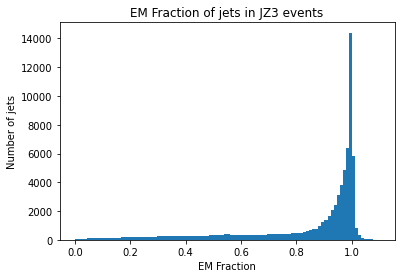

In [7]:
plt.hist(moments.emfrac, bins=100, range=(0, 1.1))
plt.xlabel('EM Fraction')
plt.ylabel('Number of jets')
_ = plt.title('EM Fraction of jets in JZ3 events')

More complex objects can come back as well. For example, vectors of floats (`std::vector<float>`). Here is a sample with the sum track $p_T$ when track $p_T > 500$ MeV.

In [8]:
sum_pt = (ds
          .SelectMany(lambda e: e.Jets("AntiKt4EMPFlowJets"))
          .Where(lambda j: (j.pt() / 1000) > 31)
          .SelectMany(lambda j: j.getAttribute[cpp_vfloat]('SumPtTrkPt500'))
          .AsAwkwardArray('sum_pt')
          .value())

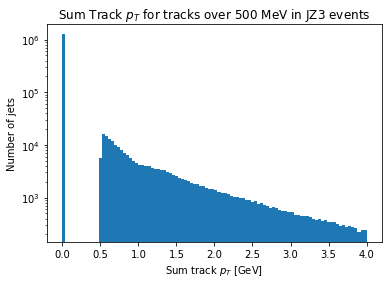

In [9]:
plt.hist(sum_pt.sum_pt/1000.0, bins=100, range=(0, 4))
plt.xlabel('Sum track $p_T$ [GeV]')
plt.ylabel('Number of jets')
plt.yscale('log')
_ = plt.title('Sum Track $p_T$ for tracks over 500 MeV in JZ3 events')

As with everything else in the ATLAS data model, even if they are reconstructed and associated with the jet, they can be stripped out with slimming - so just because they are declared on the Run 2 Moments page, it doesn't mean they actually exist in the data file you are looking at.

## Calibration

By default the jets we pulled from above are calibrated, and the best central value for the jet collection you request is returned. This section shows you how to:

* Pull out the raw, uncalibrated jets
* How to get a particular systematic variation

Because we want to do a comparison, and the jet corrections change the number of jets, we will need to do jet matching, which means doing it inside each event. Lets get the default calibration with eta and phi:

In [10]:
jets = (ds
        .Select(lambda e: e.Jets("AntiKt4EMPFlowJets")
                           .Where(lambda j: (j.pt() / 1001) > 30))
        .Select(lambda jets: {
            'pt': jets.Select(lambda j: j.pt() / 1000.0),
            'eta': jets.Select(lambda j: j.eta()),
            'phi': jets.Select(lambda j: j.phi()),
        })
        .AsAwkwardArray()
        .value())

To grab the raw jets (without calibration) we just set the `calibrated` parameter to `False` (there is very little reason one will do this normally):

In [11]:
raw_jets = (ds
           .Select(lambda e: e.Jets("AntiKt4EMPFlowJets", calibration=None)
                              .Where(lambda j: (j.pt() / 1000) > 30))
           .Select(lambda jets: {
                'pt': jets.Select(lambda j: j.pt() / 1000.0),
                'eta': jets.Select(lambda j: j.eta()),
                'phi': jets.Select(lambda j: j.phi()),
           })
           .AsAwkwardArray()
           .value())

The number of raw jets and the number of calibrated jets are quite different from the number of raw jets, so we'll need to match them in $\eta$ and $\phi$:

In [12]:
len(raw_jets), len(jets)

(40000, 40000)

In [13]:
def match(jets, jets_to_match):
    'Find the closest eta/phi jet in jets_to_match for each jet in jets'

    to_match_pt = jets_to_match.pt
    to_match_eta = jets_to_match.eta
    to_match_phi = jets_to_match.phi
    jet_eta = jets.eta
    jet_phi = jets.phi

    pair_eta = ak.cartesian([jet_eta, to_match_eta], axis=1, nested=True)
    pair_phi = ak.cartesian([jet_phi, to_match_phi], axis=1, nested=True)

    delta_eta = np.abs(pair_eta[:, :, :]["0"] - pair_eta[:, :, :]["1"])
    # TODO: Missing wrap around fro phi
    delta_phi = np.abs(pair_phi[:, :, :]["0"] - pair_phi[:, :, :]["1"])

    delta = delta_eta**2 + delta_phi**2

    # TODO: remove anything larger that 0.2*0.2
    best_match = ak.argmin(delta, axis=2)

    return ak.Record({"eta": to_match_eta[best_match], "phi": to_match_phi[best_match], "pt": to_match_pt[best_match]})

raw_jets_matched = match(jets, raw_jets)

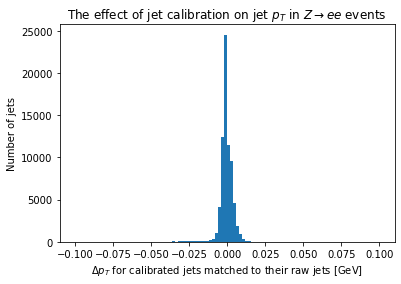

In [14]:
plt.hist(ak.flatten(jets.pt-raw_jets_matched.pt)/1000.0, bins=100, range=(-0.1, 0.1))
plt.xlabel('$\Delta p_T$ for calibrated jets matched to their raw jets [GeV]')
plt.ylabel('Number of jets')
_ = plt.title('The effect of jet calibration on jet $p_T$ in $Z\\rightarrow ee$ events')

If we instead want a particular systematic error, we need only name that error to get it back. Knowing what the names of the systematic errors, however, is not something that can be programmatically determined ahead of time. See the further information section at the end of this chapter to links to the ATLAS jet calibration info twiki.

In [15]:
sys_jets = (ds
           .Select(lambda e: e.Jets("AntiKt4EMPFlowJets", calibration="JET_Pileup_PtTerm__1up")
                              .Where(lambda j: (j.pt() / 1000) > 30))
           .Select(lambda jets: {
                'pt': jets.Select(lambda j: j.pt() / 1000.0),
                'eta': jets.Select(lambda j: j.eta()),
                'phi': jets.Select(lambda j: j.phi()),
           })
           .AsAwkwardArray()
           .value())

In [16]:
sys_jets_matched = match(jets, sys_jets)

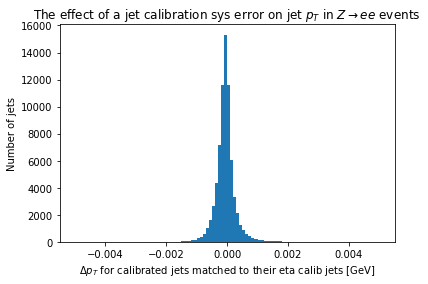

In [17]:
plt.hist(ak.flatten(jets.pt-sys_jets_matched.pt)/1000.0, bins=100, range=(-0.005, 0.005))
plt.xlabel('$\Delta p_T$ for calibrated jets matched to their eta calib jets [GeV]')
plt.ylabel('Number of jets')
_ = plt.title('The effect of a jet calibration sys error on jet $p_T$ in $Z\\rightarrow ee$ events')

Currently you only get the calibration constants that are built into the release. If you need to pin a particular calibration, get in touch.

## The Datamodel

The data model when this documentation was last built was:

In [18]:
from func_adl_servicex_xaodr21.xAOD.jet_v1 import Jet_v1
help(Jet_v1)

Help on class Jet_v1 in module func_adl_servicex_xaodr21.xAOD.jet_v1:

class Jet_v1(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  btagging(self) -> 'func_adl_servicex_xaodr21.xAOD.btagging_v1.BTagging_v1'
 |      A method
 |  
 |  btaggingLink(self) -> 'func_adl_servicex_xaodr21.elementlink_datavector_xaod_btagging_v1__.ElementLink_DataVector_xAOD_BTagging_v1__'
 |      A method
 |  
 |  clearDecorations(self) -> 'bool'
 |      A method
 |  
 |  constituentLinks(self) -> 'func_adl_servicex_xaodr21.vector_elementlink_datavector_xaod_iparticle___.vector_ElementLink_DataVector_xAOD_IParticle___'
 |      A method
 |  
 |  e(self) -> 'float'
 |      A method
 |  
 |  eta(self) -> 'float'
 |      A method
 |  
 |  getConstituents(self) -> 'func_adl_servicex_xaodr21.xAOD.jetconstituentvector.JetConstituentVector'
 |      A method
 |  
 |  getSizeParameter(self) -> 'float'
 |      A method
 |  
 |  hasNonConstStore(self) -> 'bool'
 |      A method
 |  
 |  hasStore(self)

In [19]:
from func_adl_servicex_xaodr21.xAOD.jetconstituent import JetConstituent
help(JetConstituent)

Help on class JetConstituent in module func_adl_servicex_xaodr21.xAOD.jetconstituent:

class JetConstituent(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  e(self) -> 'float'
 |      A method
 |  
 |  eta(self) -> 'float'
 |      A method
 |  
 |  isSpacelike(self) -> 'bool'
 |      A method
 |  
 |  isTimelike(self) -> 'bool'
 |      A method
 |  
 |  m(self) -> 'float'
 |      A method
 |  
 |  phi(self) -> 'float'
 |      A method
 |  
 |  pt(self) -> 'float'
 |      A method
 |  
 |  rapidity(self) -> 'float'
 |      A method
 |  
 |  rawConstituent(self) -> 'func_adl_servicex_xaodr21.xAOD.iparticle.IParticle'
 |      A method
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



## Further Information

* The [`xAOD::Jet_v1` C++ header file](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODJet/xAODJet/versions/Jet_v1.h) with all the inline documentation.
* The [`xAOD::JetConstituent` C++ header File](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODJet/xAODJet/JetConstituentVector.h) with all the inline documentation.
* The [Jet ET-Miss Recommendation Pages for R21](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/JetEtmissRecommendationsR21) on the ATLAS TWiki
* The [Run 2 Moments Page](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/Run2JetMoments)